Double CNN architecture with entropy based slicing for classifying AD vs CN

In [29]:
import pandas as pd
import nibabel as nib

In [30]:
df = pd.read_csv("/kaggle/input/adni-processed/ADNI1_Complete_1Yr_1.5T_6_20_2025.csv")

In [31]:
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,NaN
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,NaN
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,NaN
3,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,NaN
4,I105437,941_S_1202,CN,M,79,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/28/2008,NiFTI,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2289,I118671,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,4/18/2006,NiFTI,NaN
2290,I118692,002_S_0295,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,11/02/2006,NiFTI,NaN
2291,I64025,002_S_0295,CN,M,86,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/25/2007,NiFTI,NaN
2292,I45108,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,NaN


In [32]:
df.describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Age,Downloaded
count,2294.000000,0.0
mean,75.638622,NaN
std,6.662227,NaN
min,55.000000,NaN
25%,72.000000,NaN
50%,76.000000,NaN
75%,80.000000,NaN
max,91.000000,NaN


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Image Data ID  2294 non-null   object 
 1   Subject        2294 non-null   object 
 2   Group          2294 non-null   object 
 3   Sex            2294 non-null   object 
 4   Age            2294 non-null   int64  
 5   Visit          2294 non-null   object 
 6   Modality       2294 non-null   object 
 7   Description    2294 non-null   object 
 8   Type           2294 non-null   object 
 9   Acq Date       2294 non-null   object 
 10  Format         2294 non-null   object 
 11  Downloaded     0 non-null      float64
dtypes: float64(1), int64(1), object(10)
memory usage: 215.2+ KB


Getting all Image Data ID available in dataset

In [34]:
import os

def get_all_i_folders_kaggle(root_path):
    """
    Recursively find all folders that start with 'I' and return their names.
    """
    i_folders = []
    for dirpath, dirnames, filenames in os.walk(root_path):
        for dirname in dirnames:
            if dirname.startswith('I') and dirname[1:].isdigit():
                i_folders.append(dirname)
    return i_folders

# Usage
kaggle_root = "/kaggle/input/adni-processed/ADNI1_Processed/ADNI1_Processed"
i_folders = get_all_i_folders_kaggle(kaggle_root)

print(f"Found {len(i_folders)} I folders:")

Found 459 I folders:


Filtering csv file based on current dataset

In [35]:
df['Image Data ID'] = df['Image Data ID'].astype(str)
filtered_df = df[df['Image Data ID'].isin(i_folders)]
print(f"Filtered from {len(df)} → {len(filtered_df)} rows")
filtered_df = filtered_df[filtered_df['Group'] != 'MCI'] # Removing MCI subject images
print(f"Original rows: {len(df)}, Filtered rows: {len(filtered_df)}")

Filtered from 2294 → 459 rows
Original rows: 2294, Filtered rows: 234


In [36]:
filtered_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
7,I66462,941_S_1197,CN,F,82,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/20/2007,NiFTI,NaN
11,I75141,941_S_1194,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/22/2007,NiFTI,NaN
21,I92415,141_S_1137,AD,F,82,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/26/2007,NiFTI,NaN
26,I107952,141_S_1094,CN,M,77,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/19/2008,NiFTI,NaN
42,I47744,141_S_0852,AD,F,84,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/25/2006,NiFTI,NaN


In [37]:
folder_path = '/kaggle/input/adni-processed/ADNI1_Processed/ADNI1_Processed'
paths = []

Storing `.nii` file path along with its label

In [38]:
import os
from tqdm import tqdm

paths = []

for subject in os.listdir(folder_path):
    subject_path = os.path.join(folder_path, subject)
    for root_dir, dirs, files in os.walk(subject_path):
        for d in dirs:
            i_folder = os.path.join(root_dir, d)
            for f in os.listdir(i_folder):
                if f.endswith(".nii") or f.endswith(".nii.gz"):
                    nii_file = os.path.join(i_folder, f)
                    row = df[df['Image Data ID'].astype(str).str.strip() == str(d).strip()]
                    if not row.empty:
                        label = row["Group"].values[0]
                        paths.append((label, nii_file))
                    else:
                        print(f"No label found for: {d}")
                    break
print("All files scanned")

All files scanned


In [39]:
len(paths)

459

In [40]:
paths[0]

('MCI',
 '/kaggle/input/adni-processed/ADNI1_Processed/ADNI1_Processed/133_S_0913/I92637/ADNI_133_S_0913_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080225185003300_S35319_I92637_mni_norm.nii')

In [41]:
scan_1 = nib.load(paths[0][1])
data_1 = scan_1.get_fdata()
header = scan_1.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : -0.70710677
quatern_d       : 0.70710677
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [-1.  0.  0.  0.

In [42]:
print(data_1.shape)
print(data_1[0,:,:])

(256, 256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [43]:
data_1.shape[0]

256

In [44]:
filtered_paths = []
filtered_paths

[]

In [45]:
for path in paths:
    if path[0] in ('AD', 'CN'):
        filtered_paths.append(path)

In [46]:
X = []
y = []

**Generating Dataset** <br>
Taking top 30 slices based on entropy for each 3D scan

In [47]:
import nibabel as nib
import numpy as np
import cv2
from tqdm import tqdm
from scipy.stats import entropy
from skimage.exposure import histogram

def center_crop(img, size=128):
    h, w = img.shape
    if h < size or w < size:
        return None
    h_start = (h - size) // 2
    w_start = (w - size) // 2
    return img[h_start:h_start + size, w_start:w_start + size]

def image_entropy(img):
    hist = np.histogram(img, bins=256)[0]
    hist = hist / (hist.sum() + 1e-6)
    entropy = -np.sum(hist * np.log2(hist + 1e-6))
    return entropy

X, y = [], []

for path in tqdm(filtered_paths):
    scan = nib.load(path[1])
    data = scan.get_fdata()
    label = 0 if path[0] == 'AD' else 1

    slice_info = []

    for axis in range(3):  # axis 0,1,2 -> axial, coronal, sagittal
        for i in range(data.shape[axis]):
            if axis == 0:
                slice_ = data[i, :, :]
            elif axis == 1:
                slice_ = data[:, i, :]
            else:
                slice_ = data[:, :, i]

            cropped = center_crop(slice_)
            if cropped is None:
                continue

            ent = image_entropy(cropped)
            slice_info.append((ent, cropped.copy()))

    # Sort by entropy and keep top 30
    slice_info.sort(reverse=True, key=lambda x: x[0])
    top_slices = slice_info[:30]

    for _, img in top_slices:
        # Resize slice
        resized = cv2.resize(img, (224, 224))
        tensor = np.stack([resized]*3, axis = -1) # Stack thrice to create three channel tensor
        # Normalize to [0, 1]
        tensor = tensor.astype(np.float32) / 255.0
        X.append(tensor)
        y.append(label)

100%|██████████| 234/234 [02:19<00:00,  1.68it/s]


In [48]:
X = np.array(X, dtype='float32')
y = np.array(y, dtype='int')

In [49]:
X.shape

(7020, 224, 224, 3)

In [50]:
y.shape

(7020,)

Train Test Split

In [51]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print(len(X_train) == len(y_train))
print(len(X_test) == len(y_test))

True
True


**Model Architecture** <br>
Double CNN architecture which is concatenated in classification layer.

In [52]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import regularizers

#Added Regularization to reduce overfitting

# --- CNN1 Branch ---
def build_cnn1(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.Conv2D(16, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    return models.Model(inputs, x, name="CNN1")

# --- CNN2 Branch ---
def build_cnn2(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, (5, 5), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.Conv2D(32, (5, 5), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (5, 5), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Conv2D(128, (5, 5), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (5, 5), activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    return models.Model(inputs, x, name="CNN2")

# --- Combined Model ---
input_shape = (224, 224, 3)
cnn1 = build_cnn1(input_shape)
cnn2 = build_cnn2(input_shape)

combined = layers.Concatenate()([cnn1.output, cnn2.output])
x = layers.Dense(1, activation='sigmoid')(combined)  # Binary classification

model = models.Model(inputs=[cnn1.input, cnn2.input], outputs=x)

# Compile the model for binary classification
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 222, 222, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 220, 220, 32)   │          2,432 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 220, 220, 16)   │          2,320 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 216, 216, 32)   │         25,632 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 110, 110, 16)   │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 108, 108, 32)   │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 108, 108, 64)   │          9,280 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 104, 104, 128)  │        102,528 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 106, 106, 64)   │         36,928 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 100, 100, 128)  │        409,728 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 53, 53, 64)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 50, 50, 128)    │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 51, 51, 256)    │        147,712 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 46, 46, 512)    │      1,638,912 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8      

 Total params: 57,528,049 (219.45 MB)

 Trainable params: 57,526,513 (219.45 MB)

 Non-trainable params: 1,536 (6.00 KB)

Adding Early Stopping and lr reduction methods to mitigate overfitting

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

Training the Model

In [54]:
model_history = model.fit([X_train, X_train], y_train, batch_size=25, epochs=20, validation_split=0.2, callbacks=[early_stop, reduce_lr])

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 81s 378ms/step - accuracy: 0.6519 - loss: 1.6648 - val_accuracy: 0.7215 - val_loss: 0.8715 - learning_rate: 0.0010
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 56s 313ms/step - accuracy: 0.8827 - loss: 0.5255 - val_accuracy: 0.7055 - val_loss: 0.8681 - learning_rate: 0.0010
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 55s 305ms/step - accuracy: 0.9464 - loss: 0.4350 - val_accuracy: 0.4475 - val_loss: 1.4009 - learning_rate: 0.0010
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 56s 309ms/step - accuracy: 0.9701 - loss: 0.4176 - val_accuracy: 0.8701 - val_loss: 0.6571 - learning_rate: 0.0010
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 55s 307ms/step - accuracy: 0.9800 - loss: 0.4016 - val_accuracy: 0.8345 - val_loss: 0.8272 - learning_rate: 0.0010
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9824 - loss: 0.3991
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
180/180 ━━━━━━━━━━━━━━━━━━━━ 55s 308ms/step - accuracy: 0.982

Test Dataset

In [55]:
model_evaluation = model.evaluate(x=[X_test, X_test],y=y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.9899 - loss: 0.1926


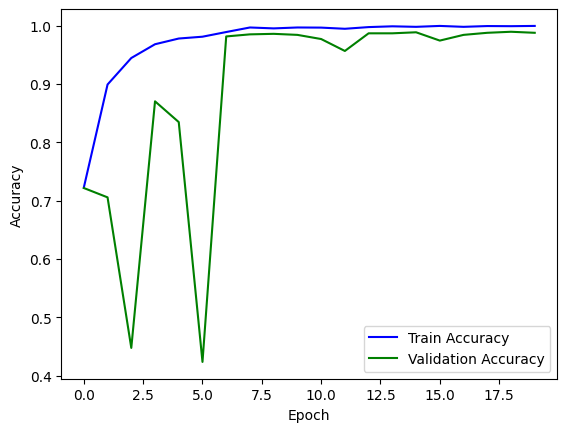

In [56]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['accuracy'],color='Blue',label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'],color='Green',label='Validation Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()